In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot
import eelbrain
import mne
from eelbrain import *
#import trftools
from eelbrain import testnd

from pprint import pprint
import numpy as np
from scipy import stats
import pandas as pd
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

/Users/neuroling/anaconda3/envs/eelbrain/lib/python3.11/site-packages/eelbrain/mne_fixes/_interpolation.py:13: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.pick import pick_types, pick_channels
/Users/neuroling/anaconda3/envs/eelbrain/lib/python3.11/site-packages/eelbrain/mne_fixes/_interpolation.py:13: FutureWarning: mne.io.pick.pick_channels is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.pick import pick_types, pick_channels


In [3]:
## Load in ESLs data ##

#STIMULI = [str(i) for i in range(1, 13)]
#DATA_ROOT = Path("/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results")  #Path("~").expanduser() / 'Data' / 'Alice'
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
#PREDICTOR_audio_DIR = DATA_ROOT / 'TRFs_pridictors/audio_predictors'
#PREDICTOR_word_DIR = DATA_ROOT / 'TRFs_pridictors/word_predictors'
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
IMF_DIR = DATA_ROOT/ "TRFs_pridictors/IF_predictors"
F0_DIR = DATA_ROOT/ "TRFs_pridictors/F0_predictors"
IMFsLIST = [path.name for path in IMF_DIR.iterdir() if re.match(r'Alice_IF_IMF_*', path.name)] 
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]  #S01_alice-raw.fif

# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'
TRF_DIR.mkdir(exist_ok=True)
print(ESL_SUBJECTS)
print(len(ESL_SUBJECTS))  # 26
DST = TRF_DIR / 'ESLs_figures'
DST.mkdir(exist_ok=True)

['n_2_S030_ICAed_raw.fif', 'n_2_S027_ICAed_raw.fif', 'n_2_S023_ICAed_raw.fif', 'n_2_S034_ICAed_raw.fif', 'n_2_S024_ICAed_raw.fif', 'n_2_S019_ICAed_raw.fif', 'n_2_S020_ICAed_raw.fif', 'n_2_S013_ICAed_raw.fif', 'n_2_S017_ICAed_raw.fif', 'n_2_S039_ICAed_raw.fif', 'n_2_S010_ICAed_raw.fif', 'n_2_S029_ICAed_raw.fif', 'n_2_S015_ICAed_raw.fif', 'n_2_S028_ICAed_raw.fif', 'n_2_S011_ICAed_raw.fif', 'n_2_S038_ICAed_raw.fif', 'n_2_S016_ICAed_raw.fif', 'n_2_S012_ICAed_raw.fif', 'n_2_S021_ICAed_raw.fif', 'n_2_S036_ICAed_raw.fif', 'n_2_S032_ICAed_raw.fif', 'n_2_S025_ICAed_raw.fif', 'n_2_S035_ICAed_raw.fif', 'n_2_S022_ICAed_raw.fif', 'n_2_S026_ICAed_raw.fif', 'n_2_S031_ICAed_raw.fif']
26


In [4]:
## VST score of each sub ##
VST_Score_STR_LIST = ['6.7', '7.3', '7.8', '8.2', '8.4', '6.4', '7.5', '6.7', '5.2', '5.3', '6.5'
                 , '5.1', '6.1', '7.9', '8.7', '8.0', '8.8', '6.4', '7.0', '7.4', '6.6', '7.2'
                 , '7.0', '7.3', '7.3', '7.7']  # 26 subs
VST_Score_float_LIST = [6.7, 7.3, 7.8, 8.2, 8.4, 6.4, 7.5, 6.7
                        , 5.2, 5.3, 6.5, 5.1, 6.1, 7.9, 8.7, 8.0
                        , 8.8, 6.4, 7.0, 7.4, 6.6, 7.2, 7.0, 7.3, 7.3, 7.7]
# exclude sub: 14 / 18 / 33 / 37
sub_idLIST = [10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27
              , 28, 29, 30, 31, 32, 34, 35, 36, 38, 39]
# Female = 1; Male = 2
sub_SexLIST = ["F", "M", "M", "F", "F", "M", "F", "M", "M", "F", "M", "F", "F", "M", "F", "M", "F", "M", "F", "M", "F", "M", "F", "M", "F", "M"]
 
# dictionary of lists 
VST_df = pd.DataFrame({'id': sub_idLIST, 'VST': VST_Score_float_LIST, 'gender':sub_SexLIST})
   
#VST_df = pd.DataFrame(id_VST_DICT)
   
#print(VST_df) 
#print(type(VST_df["VST"][0]))
print(VST_df.loc[0])

id         10
VST       6.7
gender      F
Name: 0, dtype: object


In [7]:
## GET the VST score according to the sub_id ##
for subject in ESL_SUBJECTS:
    #print(type(subject[4:8]))
    #print(subject[6:8])
    #print(int(subject[6:8]), ">>>", VST_df.loc[VST_df["id"]==int(subject[6:8])])
    #print(int(subject[6:8]), ">>>", VST_df.loc[VST_df["id"]==int(subject[6:8])]["VST"])

    VST_scoreFLOAT = float(VST_df.loc[VST_df["id"]==int(subject[6:8])]["VST"])
    
    print("SUB", subject[6:8], "VST score = ", VST_scoreFLOAT)

SUB 30 VST score =  7.0
SUB 27 VST score =  8.0
SUB 23 VST score =  5.1
SUB 34 VST score =  7.2
SUB 24 VST score =  6.1
SUB 19 VST score =  6.7
SUB 20 VST score =  5.2
SUB 13 VST score =  8.2
SUB 17 VST score =  7.5
SUB 39 VST score =  7.7
SUB 10 VST score =  6.7
SUB 29 VST score =  6.4
SUB 15 VST score =  8.4
SUB 28 VST score =  8.8
SUB 11 VST score =  7.3
SUB 38 VST score =  7.3
SUB 16 VST score =  6.4
SUB 12 VST score =  7.8
SUB 21 VST score =  5.3
SUB 36 VST score =  7.3
SUB 32 VST score =  6.6
SUB 25 VST score =  7.9
SUB 35 VST score =  7.0
SUB 22 VST score =  6.5
SUB 26 VST score =  8.7
SUB 31 VST score =  7.4


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_90267/3345738907.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  VST_scoreFLOAT = float(VST_df.loc[VST_df["id"]==int(subject[6:8])]["VST"])


In [8]:
## Import the model of F0 & Envelope & Onset TRF of ESLs ##
# Compare the TRFs corresponding to F0 and Envelopes.

# Build the model_data['model']
models = ['Fzero', 'Fzero+envelope', 'Fzero+envelope+env_onset'] # Change the description
rows = []
for model in models:
    print(model)
    for subject in ESL_SUBJECTS:
        trf = eelbrain.load.unpickle(TRF_DIR / subject[4:8] / f'{subject[4:8]} {model}.pickle')
        #print(trf)
        trf.x = ['f0', 'f0env', 'f0envenvon'] #rename the model (no punctuation)
        #rows.append([n_subj, model, *trf.h_scaled])
        rows.append([subject, model, trf.proportion_explained])

model_data = eelbrain.Dataset.from_caselist(['subject', 'model', 'det'], rows)
#pprint(rows)
print(model_data)

# For more interpretable numbers, express proportion explained in terms of the maximum explained variability of the most complete model
index = model_data['model'] == 'IMFAll'
model_data['det'] *= 100 / model_data[index, 'det'].mean('case').max('sensor')
# ['IMF_6', 'IMF_4', 'IMF_2', 'IMF_5', 'IMF_1', 'IMF_3'] >> the supposed model names??  >> why would IMF_6 popped up??

Fzero
Fzero+envelope
Fzero+envelope+env_onset
subject                  model                   
-------------------------------------------------
n_2_S030_ICAed_raw.fif   Fzero                   
n_2_S027_ICAed_raw.fif   Fzero                   
n_2_S023_ICAed_raw.fif   Fzero                   
n_2_S034_ICAed_raw.fif   Fzero                   
n_2_S024_ICAed_raw.fif   Fzero                   
n_2_S019_ICAed_raw.fif   Fzero                   
n_2_S020_ICAed_raw.fif   Fzero                   
n_2_S013_ICAed_raw.fif   Fzero                   
n_2_S017_ICAed_raw.fif   Fzero                   
n_2_S039_ICAed_raw.fif   Fzero                   
n_2_S010_ICAed_raw.fif   Fzero                   
n_2_S029_ICAed_raw.fif   Fzero                   
n_2_S015_ICAed_raw.fif   Fzero                   
n_2_S028_ICAed_raw.fif   Fzero                   
n_2_S011_ICAed_raw.fif   Fzero                   
n_2_S038_ICAed_raw.fif   Fzero                   
n_2_S016_ICAed_raw.fif   Fzero                   
n_2_

/Users/neuroling/anaconda3/envs/eelbrain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/neuroling/anaconda3/envs/eelbrain/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/Users/neuroling/anaconda3/envs/eelbrain/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [45]:
n_rows = []
n_VST_trf_hscaledLIST = []
for subject in ESL_SUBJECTS:
    n_subj = int(subject[5:8])
    n_trf = eelbrain.load.unpickle(TRF_DIR / subject[4:8] / f'{subject[4:8]} Fzero+envelope+env_onset.pickle')
    print(n_trf.x)
    VST_scoreFLOAT = float(VST_df.loc[VST_df["id"]==int(subject[6:8])]["VST"])
    #VST_scoreFLOAT = int(VST_df.loc[VST_df["id"]==int(subject[6:8])]["VST"])
    #print("SUB", subject[6:8], "VST score = ", VST_scoreFLOAT)
    n_VST_trf_hscaledLIST.append([n_subj, VST_scoreFLOAT, *n_trf.h_scaled])
    #n_trf.x = ['f0', 'f0env', 'f0envenvon'] #rename the model (no punctuation)
    n_rows.append([n_subj, model, VST_scoreFLOAT, *n_trf.h_scaled])
n_trfs = eelbrain.Dataset.from_caselist(['subject', 'model', "VST" ,*n_trf.x], n_rows)
print(n_trfs)
print(type(n_trfs))

#pprint(n_VST_trf_hscaledLIST)
# subject * time, VST >> 2 dimension's correlation, r timeline draw out >> see what channels show the peak at waht time
# r & FDR to show VST's descrption statistic 

['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
subject   model                      VST
----------------------------------------
30        Fzero+envelope+env_onset   7  
27        Fzero+envelope+env_onset   8  
23        Fzero+envelope+env_o

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_90267/1288145665.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  VST_scoreFLOAT = float(VST_df.loc[VST_df["id"]==int(subject[6:8])]["VST"])


In [24]:
n_trf.h[0].sensor.names

Datalist(['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8'])

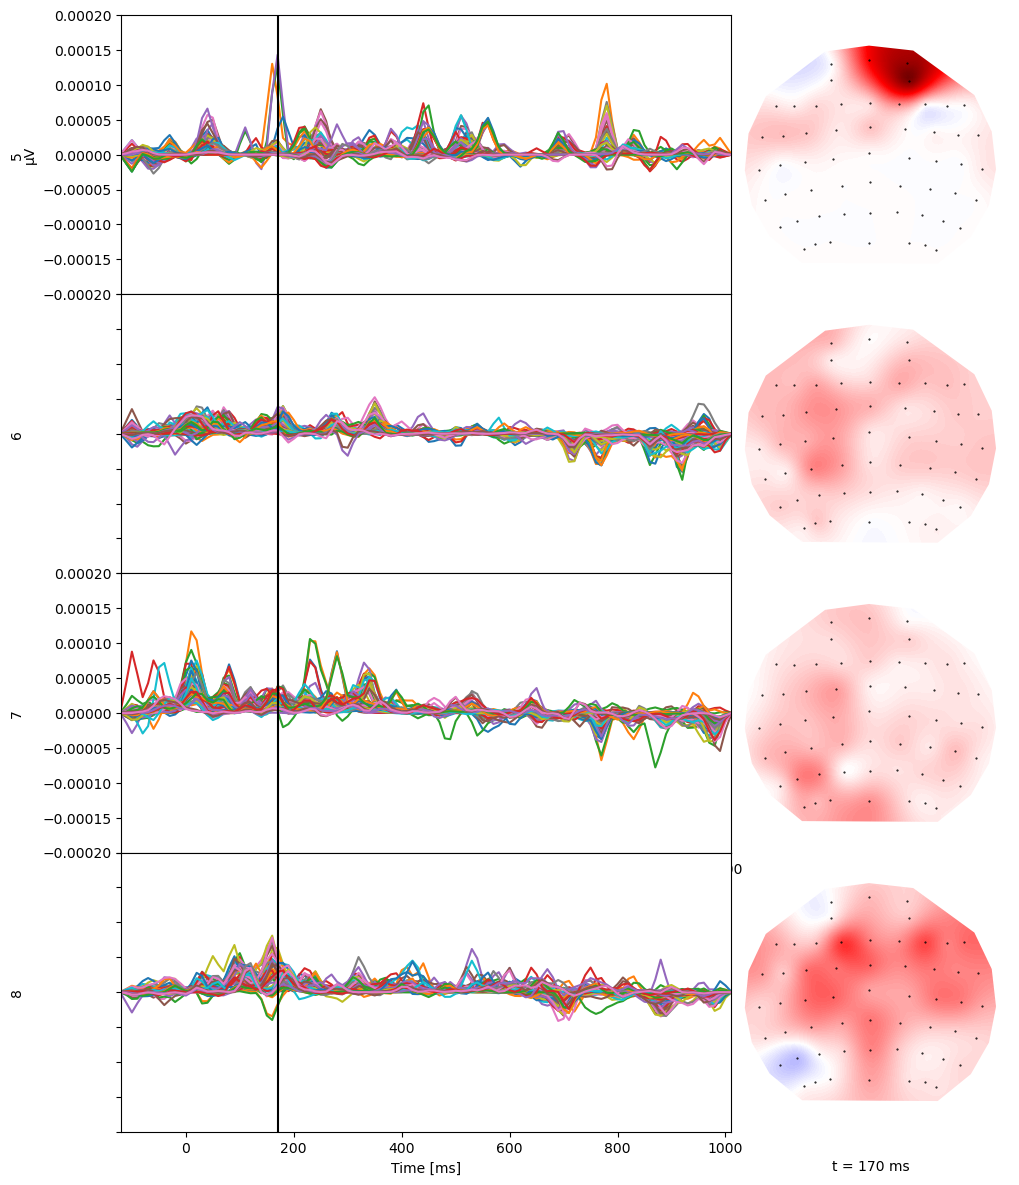

In [246]:
VST_F0_p = plot.TopoButterfly('Fzero', 'VST', data=n_trfs, t=0.17) #, axh=2, w=6)
VST_F0_p

In [46]:
print(type(n_trfs), n_trfs) #<class 'eelbrain._data_obj.Dataset'>
#print(type(n_rows), n_rows) # <class 'list'>
print(type(n_VST_trf_hscaledLIST), n_VST_trf_hscaledLIST) #<class 'list'> 

<class 'eelbrain._data_obj.Dataset'> subject   model                      VST
----------------------------------------
30        Fzero+envelope+env_onset   7  
27        Fzero+envelope+env_onset   8  
23        Fzero+envelope+env_onset   5.1
34        Fzero+envelope+env_onset   7.2
24        Fzero+envelope+env_onset   6.1
19        Fzero+envelope+env_onset   6.7
20        Fzero+envelope+env_onset   5.2
13        Fzero+envelope+env_onset   8.2
17        Fzero+envelope+env_onset   7.5
39        Fzero+envelope+env_onset   7.7
10        Fzero+envelope+env_onset   6.7
29        Fzero+envelope+env_onset   6.4
15        Fzero+envelope+env_onset   8.4
28        Fzero+envelope+env_onset   8.8
11        Fzero+envelope+env_onset   7.3
38        Fzero+envelope+env_onset   7.3
16        Fzero+envelope+env_onset   6.4
12        Fzero+envelope+env_onset   7.8
21        Fzero+envelope+env_onset   5.3
36        Fzero+envelope+env_onset   7.3
32        Fzero+envelope+env_onset   6.6
25        Fzero+enve

In [170]:
for sub_ in n_trfs:
    print(type(sub_), len(sub_), sub_)

<class 'str'> 7 subject
<class 'str'> 5 model
<class 'str'> 3 VST
<class 'str'> 5 Fzero
<class 'str'> 8 envelope
<class 'str'> 5 onset


In [47]:
# Trying to plot the graph in subject * times 

## Step 1: Gather Your Data
F0_all_LIST = []
subject_namesLIST = []
VST_all_LIST = []
for sub_ in n_rows:
    #print(type(sub_[0]), sub_[0])
    #print(type(sub_[3]), sub_[3])
    sub_VST = sub_[2]
    sub_F0 = sub_[3] #.get_data()
    #sub_env = sub_[4]
    #sub_envOn = sub_[5]
    #print(sub_[0], sub_F0, sub_VST)
    #print(sub_F0.name)  # dims = (<Sensor n=57, name=None>, UTS(-0.12000000000000001, 0.01, 114))
    # Create a list of subject names (e.g., "sub1", "sub2", ..., "sub26")
    subject_namesLIST.append(f"sub{sub_[0]}") #subject_names = [f"sub{i+1}" for i in range(n_subjects)]

    VST_all_LIST.append(sub_VST)
    
    F0data = sub_F0.x
    
    #print(F0data.shape)
    #print(sub_F0.get_dims)
    
    F0_all_LIST.append(F0data)


# get the sub * sensor * time ## 26*57*114
F0_3D_Array = np.stack(F0_all_LIST, axis=0)
print(F0_3D_Array)


print(len(VST_all_LIST))

[[[-3.09309692e-06 -2.18063333e-05 -4.49272328e-05 ...  0.00000000e+00
   -9.10822116e-21  3.38037074e-21]
  [-1.82211191e-22 -3.64422382e-22  5.58021772e-22 ...  1.45768953e-21
    7.28844764e-22  0.00000000e+00]
  [ 0.00000000e+00 -1.92657228e-21 -7.22464604e-22 ... -5.35464629e-06
   -7.93280931e-07 -3.13357350e-21]
  ...
  [ 3.81414146e-21  3.17845122e-22  1.54949497e-21 ... -4.44983170e-21
   -4.44983170e-21 -6.35690243e-21]
  [ 5.09115677e-21 -1.27278919e-21 -1.82963446e-21 ... -3.81836758e-21
   -4.77295947e-21 -2.54557839e-21]
  [ 5.08683531e-21  6.35854414e-22  7.94818017e-22 ... -5.08683531e-21
   -3.17927207e-21 -7.63025296e-21]]

 [[ 1.24414675e-21  1.24414675e-21 -4.66555031e-22 ...  0.00000000e+00
    3.11036687e-21 -2.48829350e-21]
  [ 3.02493094e-21  4.23490331e-21  3.62991713e-21 ...  1.24778401e-21
    3.02493094e-22 -2.41994475e-21]
  [ 1.96606567e-06  1.32709433e-05  2.45758209e-05 ... -2.78530722e-21
   -5.96851547e-21  1.19370309e-21]
  ...
  [ 2.22173532e-21 -1.6

In [211]:
print(F0_3D_Array.shape[1])
print(F0_3D_Array[0].get_dims)

57


AttributeError: 'numpy.ndarray' object has no attribute 'get_dims'

In [31]:
## Step 2: Compute Correlation for Each Sensor at Each Time ##
# create the vst into sub*VST_score
VST_array = np.array(VST_all_LIST)
#print(VST_array.shape, VST_array)

n_subjects, n_sensors, n_timepoints = F0_3D_Array.shape
r_vals = np.zeros((n_sensors, n_timepoints))
p_vals = np.zeros((n_sensors, n_timepoints))

for ch in range(n_sensors):      # For each sensor
    for t in range(n_timepoints):  # For each time point
        # This extracts the vector from all subjects for sensor ch at time t
        values = F0_3D_Array[:, ch, t]
        r, p = pearsonr(values, VST_array)  # Compute correlation (r) and p-value (p)
        r_vals[ch, t] = r
        p_vals[ch, t] = p

print(">>> r_vals")
print(type(r_vals))

print(">>> p_vals")
print(type(p_vals))

>>> r_vals
<class 'numpy.ndarray'>
>>> p_vals
<class 'numpy.ndarray'>


In [21]:
## Step 3: Clean Up the Results with FDR Correction ##
#from statsmodels.stats.multitest import multipletests

p_vals_flat = p_vals.flatten()
rej_flat, pvals_corrected, _, _ = multipletests(p_vals_flat, alpha=0.05, method='fdr_bh')
rej = rej_flat.reshape(n_sensors, n_timepoints)  # Now rej is a grid of True/False values

print(rej)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [54]:
## 4A. Butterfly Plot (All Sensors Overlaid)
"""
#import matplotlib.pyplot as plt

time = np.linspace(0, 1, n_timepoints)  # Suppose time is from 0 to 1 second

plt.figure(figsize=(8, 5))
for ch in range(n_sensors):
    plt.plot(time, r_vals[ch, :], color='gray', alpha=0.5)  # color='gray'
plt.xlabel('Time (s)')
plt.ylabel('Correlation coefficient (r)')
plt.title('Butterfly Plot: All Sensor Correlation Timelines')
plt.grid(True)
plt.show()
"""

"\n#import matplotlib.pyplot as plt\n\ntime = np.linspace(0, 1, n_timepoints)  # Suppose time is from 0 to 1 second\n\nplt.figure(figsize=(8, 5))\nfor ch in range(n_sensors):\n    plt.plot(time, r_vals[ch, :], color='gray', alpha=0.5)  # color='gray'\nplt.xlabel('Time (s)')\nplt.ylabel('Correlation coefficient (r)')\nplt.title('Butterfly Plot: All Sensor Correlation Timelines')\nplt.grid(True)\nplt.show()\n"

In [59]:
## 4B. Topographic Array (Small Multiples for Each Sensor)
n_cols = 5  # How many plots per row
n_rows = int(np.ceil(n_sensors / n_cols))
time = np.linspace(0, 1, n_timepoints)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 12), sharex=True, sharey=True)
axs = axs.flatten()  # Make it easier to loop through

sensor_names = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 
                'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 
                'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 
                'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 
                'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 
                'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8']


for ch in range(n_sensors):
    """
    # Using ax
    ax = axs[ch]
    ax.plot(time, r_vals[ch, :], color='blue')
    # Mark significant time points with red dots:
    sig_times = time[rej[ch, :]]
    sig_r = r_vals[ch, :][rej[ch, :]]
    ax.scatter(sig_times, sig_r, color='red', s=10)
    # Set the title using the sensor name from the list
    #ax.set_title(f'Sensor {ch}')
    ax.set_title(sensor_names[ch])
    ax.set_ylim(-1, 1)
    ax.grid(True)
    """
    
    plt.figure(figsize=(6, 4))
    
    # Plot the correlation time series for the current sensor
    plt.plot(time, r_vals[ch, :], color='blue', label='r timeline')
    plt.axhline(0, color='black', linestyle='--', linewidth=1, label='r = 0')
    
    # Overlay significant points with red dots
    sig_times = time[rej[ch, :]]
    sig_r = r_vals[ch, :][rej[ch, :]]
    plt.scatter(sig_times, sig_r, color='red', s=10, label='Significant')
    plt.xlabel('Time (s)')
    plt.ylabel('Correlation (r)')
    plt.title(sensor_names[ch])
    #plt.show()
    plt.savefig(DST / Path(f"{sensor_names[ch]}_F0"))
"""    
# Turn off any extra subplots if there aren't enough sensors
for i in range(n_sensors, len(axs)):
    axs[i].axis('off')

fig.suptitle('Topographic Array: Each Sensor\'s r Timeline (red dots = FDR-significant)', fontsize=16)
plt.xlabel('Time (s)')
plt.ylabel('Correlation (r)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
"""

"    \n# Turn off any extra subplots if there aren't enough sensors\nfor i in range(n_sensors, len(axs)):\n    axs[i].axis('off')\n\nfig.suptitle('Topographic Array: Each Sensor's r Timeline (red dots = FDR-significant)', fontsize=16)\nplt.xlabel('Time (s)')\nplt.ylabel('Correlation (r)')\nplt.tight_layout(rect=[0, 0, 1, 0.95])\nplt.show()\n"

In [48]:
## Step 5: Identify the Peak Correlations ##

# A. Find the Peak for Each Sensor
# Create arrays to store the peak time and peak r for each sensor.
peak_time = np.zeros(n_sensors)
peak_r   = np.zeros(n_sensors)

for ch in range(n_sensors):
    # Find the index where the absolute correlation (ignoring sign) is maximum for this sensor.
    peak_idx = np.argmax(np.abs(r_vals[ch, :]))
    peak_time[ch] = time[peak_idx]
    peak_r[ch]   = r_vals[ch, peak_idx]

# Print the peak results for each sensor.
for ch in range(n_sensors):
    ch_names = sensor_names[ch]
    #print(f"{ch_names}")
    print(f"{ch_names}: Peak time = {peak_time[ch]:.3f} s, Correlation r = {peak_r[ch]:.3f}")

"""
F0_VST_df = pd.DataFrame({
    'Sensor': sensor_names,
    'Peak_Time (s)': peak_time,
    'Peak_Correlation': peak_r
})
"""
vst_array = np.array(VST_all_LIST)  # shape (n_subjects,)
mean_VST = np.mean(vst_array)

F0_VST_df = pd.DataFrame({
    'Sensor': sensor_names,
    'Peak_Time (s)': peak_time,
    'Peak_Correlation': peak_r,
    'Group_Mean_VST': mean_VST  # Same for every sensor
})

print(F0_VST_df)

# Display the DataFrame
print(F0_VST_df)
F0_VST_df.to_csv(DST / Path('peak_statistics.csv'), index=False)

    
"""
# B. Find the Overall Maximum Correlation Across All Sensors
# Find the overall peak: the sensor/time pair with the maximum absolute correlation.
max_idx = np.unravel_index(np.argmax(np.abs(r_vals)), r_vals.shape)
best_sensor = max_idx[0]
best_time = time[max_idx[1]]
best_r = r_vals[best_sensor, max_idx[1]]

print(f"Overall best: Sensor {best_sensor} shows the strongest correlation of r = {best_r:.3f} at time {best_time:.3f} s.")
"""

FP1: Peak time = 0.903 s, Correlation r = -0.436
FPZ: Peak time = 0.965 s, Correlation r = -0.377
FP2: Peak time = 0.221 s, Correlation r = 0.322
AF3: Peak time = 0.867 s, Correlation r = -0.477
AF4: Peak time = 0.717 s, Correlation r = -0.374
F7: Peak time = 0.832 s, Correlation r = -0.569
F5: Peak time = 0.814 s, Correlation r = -0.575
F3: Peak time = 0.850 s, Correlation r = -0.538
F1: Peak time = 0.912 s, Correlation r = -0.612
FZ: Peak time = 0.221 s, Correlation r = 0.451
F2: Peak time = 0.850 s, Correlation r = -0.454
F4: Peak time = 0.230 s, Correlation r = 0.627
F6: Peak time = 0.230 s, Correlation r = 0.537
F8: Peak time = 0.186 s, Correlation r = 0.377
FT7: Peak time = 0.195 s, Correlation r = 0.474
FC5: Peak time = 0.867 s, Correlation r = -0.516
FC3: Peak time = 0.858 s, Correlation r = -0.649
FC1: Peak time = 0.920 s, Correlation r = -0.468
FCZ: Peak time = 0.912 s, Correlation r = -0.494
FC2: Peak time = 0.204 s, Correlation r = 0.442
FC4: Peak time = 0.239 s, Correlatio

'\n# B. Find the Overall Maximum Correlation Across All Sensors\n# Find the overall peak: the sensor/time pair with the maximum absolute correlation.\nmax_idx = np.unravel_index(np.argmax(np.abs(r_vals)), r_vals.shape)\nbest_sensor = max_idx[0]\nbest_time = time[max_idx[1]]\nbest_r = r_vals[best_sensor, max_idx[1]]\n\nprint(f"Overall best: Sensor {best_sensor} shows the strongest correlation of r = {best_r:.3f} at time {best_time:.3f} s.")\n'

# Below is the old codes that use to get the sub * time(ch * time per sub)

In [299]:
## Step 4: Apply FDR Correction and Overlay Significant Points ##
#from statsmodels.stats.multitest import multipletests

# Flatten the p_vals array (which is of shape (57, 114)) to perform FDR correction on all tests
p_vals_flat = p_vals.flatten()

# Apply FDR correction at alpha = 0.05 using the Benjamini-Hochberg method
rej_flat, pvals_corrected, _, _ = multipletests(p_vals_flat, alpha=0.05, method='fdr_bh')

# Reshape the rejection mask back to the original shape (57, 114)
rej = rej_flat.reshape(n_sensors, n_timepoints)

## VERSION 1 ##
"""
# Now plot the colorful butterfly plot and overlay significant points with markers.
plt.figure(figsize=(10, 6))
for ch in range(n_sensors):
    # Plot the sensor's correlation timeline in its unique color.
    plt.plot(time, r_vals[ch, :], alpha=0.8) #, color=colors[ch]
    # Determine where FDR indicates significance for this sensor.
    sig_mask = rej[ch, :]  # This is a Boolean array for this sensor.
    # Overlay significant points as red dots (with a black edge for visibility).
    plt.scatter(time[sig_mask], r_vals[ch, :][sig_mask], color='red', edgecolor='k', s=40)  # s controls marker size  #color=colors[ch]

plt.xlabel("Time (s)")
plt.ylabel("Correlation coefficient (r)")
plt.title("Colorful Butterfly Plot with FDR-significant Points")
plt.grid(True)
plt.show()
"""
## Step 5: Identify the Peak Correlations ##

# A. Find the Peak for Each Sensor
# Create arrays to store the peak time and peak r for each sensor.
peak_time = np.zeros(n_sensors)
peak_r   = np.zeros(n_sensors)

for ch in range(n_sensors):
    # Find the index where the absolute correlation (ignoring sign) is maximum for this sensor.
    peak_idx = np.argmax(np.abs(r_vals[ch, :]))
    peak_time[ch] = time[peak_idx]
    peak_r[ch]   = r_vals[ch, peak_idx]

# Print the peak results for each sensor.
for ch in range(n_sensors):
    print(f"Sensor {ch}: Peak time = {peak_time[ch]:.3f} s, Correlation r = {peak_r[ch]:.3f}")

# B. Find the Overall Maximum Correlation Across All Sensors
# Find the overall peak: the sensor/time pair with the maximum absolute correlation.
max_idx = np.unravel_index(np.argmax(np.abs(r_vals)), r_vals.shape)
best_sensor = max_idx[0]
best_time = time[max_idx[1]]
best_r = r_vals[best_sensor, max_idx[1]]

print(f"Overall best: Sensor {best_sensor} shows the strongest correlation of r = {best_r:.3f} at time {best_time:.3f} s.")

Sensor 0: Peak time = 0.903 s, Correlation r = -0.483
Sensor 1: Peak time = 0.956 s, Correlation r = -0.404
Sensor 2: Peak time = 0.434 s, Correlation r = 0.320
Sensor 3: Peak time = 0.867 s, Correlation r = -0.426
Sensor 4: Peak time = 0.071 s, Correlation r = 0.377
Sensor 5: Peak time = 0.832 s, Correlation r = -0.586
Sensor 6: Peak time = 0.814 s, Correlation r = -0.574
Sensor 7: Peak time = 0.850 s, Correlation r = -0.583
Sensor 8: Peak time = 0.912 s, Correlation r = -0.564
Sensor 9: Peak time = 0.221 s, Correlation r = 0.398
Sensor 10: Peak time = 0.894 s, Correlation r = -0.450
Sensor 11: Peak time = 0.230 s, Correlation r = 0.589
Sensor 12: Peak time = 0.230 s, Correlation r = 0.489
Sensor 13: Peak time = 0.522 s, Correlation r = 0.339
Sensor 14: Peak time = 0.195 s, Correlation r = 0.462
Sensor 15: Peak time = 0.965 s, Correlation r = -0.449
Sensor 16: Peak time = 0.858 s, Correlation r = -0.593
Sensor 17: Peak time = 0.920 s, Correlation r = -0.514
Sensor 18: Peak time = 0.91

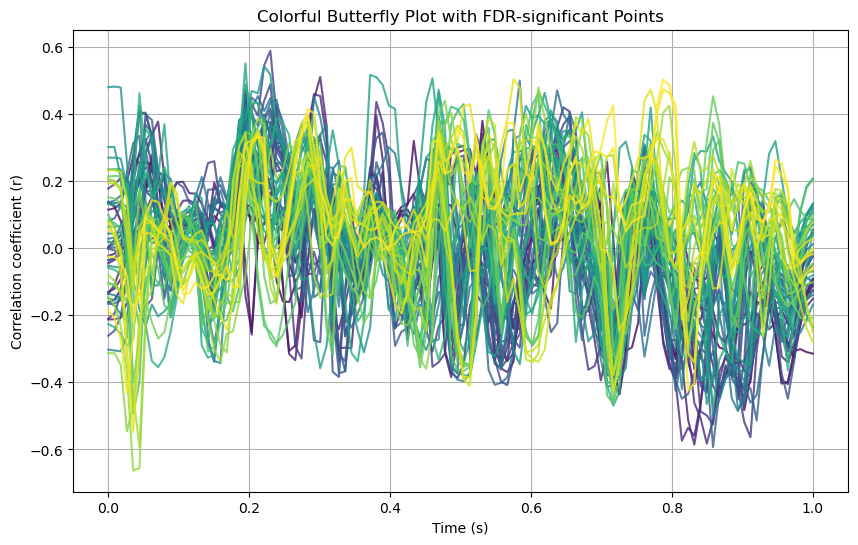

In [297]:
## VERSION 2 ##
## Step B: Colorful Butterfly Plot with Significant Points Highlighted. ##

#import matplotlib.pyplot as plt
# Suppose n_timepoints = 114, and define the time vector (e.g., 0-1 sec)
time = np.linspace(0, 1, n_timepoints)

# Get an array of colors – one for each sensor – from a colormap (here, 'viridis')
colors = plt.cm.viridis(np.linspace(0, 1, n_sensors))

plt.figure(figsize=(10, 6))
for ch in range(n_sensors):
    # Plot the r timeline for sensor 'ch' with its unique color
    plt.plot(time, r_vals[ch, :], color=colors[ch], alpha=0.8, label=f'Sensor {ch}' if ch < 10 else None)
    
    # Create a mask for significance in this sensor (True where significant)
    sig_mask = rej[ch, :]
    
    # Overlay significant points (you can choose marker style, here a larger circular marker)
    plt.scatter(time[sig_mask], r_vals[ch, :][sig_mask],
                color=colors[ch], edgecolor='k', s=40, zorder=3)  # zorder puts markers in front

plt.xlabel("Time (s)")
plt.ylabel("Correlation coefficient (r)")
plt.title("Colorful Butterfly Plot with FDR-significant Points")
plt.grid(True)
plt.show()

In [ ]:
## VERSION 1 ##
## Step 5: Identify the Peak Correlations ##

# A. Find the Peak for Each Sensor
# Create arrays to store the peak time and peak r for each sensor.
peak_time = np.zeros(n_sensors)
peak_r   = np.zeros(n_sensors)

for ch in range(n_sensors):
    # Find the index where the absolute correlation (ignoring sign) is maximum for this sensor.
    peak_idx = np.argmax(np.abs(r_vals[ch, :]))
    peak_time[ch] = time[peak_idx]
    peak_r[ch]   = r_vals[ch, peak_idx]

# Print the peak results for each sensor.
for ch in range(n_sensors):
    print(f"Sensor {ch}: Peak time = {peak_time[ch]:.3f} s, Correlation r = {peak_r[ch]:.3f}")

# B. Find the Overall Maximum Correlation Across All Sensors
# Find the overall peak: the sensor/time pair with the maximum absolute correlation.
max_idx = np.unravel_index(np.argmax(np.abs(r_vals)), r_vals.shape)
best_sensor = max_idx[0]
best_time = time[max_idx[1]]
best_r = r_vals[best_sensor, max_idx[1]]

print(f"Overall best: Sensor {best_sensor} shows the strongest correlation of r = {best_r:.3f} at time {best_time:.3f} s.")

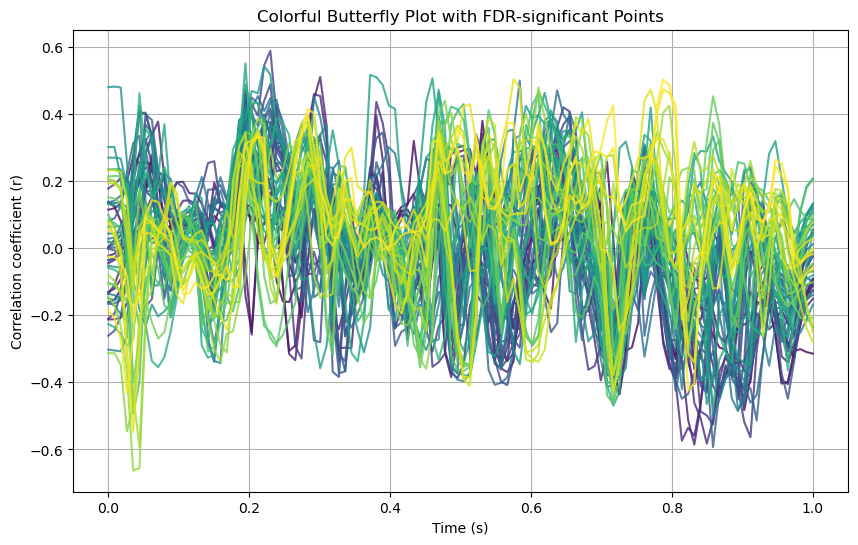

Sensor 0: Peak correlation at time = 0.903 s, r = -0.483
Sensor 1: Peak correlation at time = 0.956 s, r = -0.404
Sensor 2: Peak correlation at time = 0.434 s, r = 0.320
Sensor 3: Peak correlation at time = 0.867 s, r = -0.426
Sensor 4: Peak correlation at time = 0.071 s, r = 0.377
Sensor 5: Peak correlation at time = 0.832 s, r = -0.586
Sensor 6: Peak correlation at time = 0.814 s, r = -0.574
Sensor 7: Peak correlation at time = 0.850 s, r = -0.583
Sensor 8: Peak correlation at time = 0.912 s, r = -0.564
Sensor 9: Peak correlation at time = 0.221 s, r = 0.398
Sensor 10: Peak correlation at time = 0.894 s, r = -0.450
Sensor 11: Peak correlation at time = 0.230 s, r = 0.589
Sensor 12: Peak correlation at time = 0.230 s, r = 0.489
Sensor 13: Peak correlation at time = 0.522 s, r = 0.339
Sensor 14: Peak correlation at time = 0.195 s, r = 0.462
Sensor 15: Peak correlation at time = 0.965 s, r = -0.449
Sensor 16: Peak correlation at time = 0.858 s, r = -0.593
Sensor 17: Peak correlation at 

'\n# Find the overall maximum absolute correlation across all sensors.\noverall_peak_idx = np.unravel_index(np.argmax(np.abs(r_vals)), r_vals.shape)\nbest_sensor = overall_peak_idx[0]\nbest_time = time[overall_peak_idx[1]]\nbest_r = r_vals[best_sensor, overall_peak_idx[1]]\nprint(f"Overall highest: Sensor {best_sensor} with r = {best_r:.3f} at time = {best_time:.3f} s")\n'

In [296]:
## VERSION 3 ##
## 2. Colorful Butterfly Plot with Significant Points Overlaid ##
#import matplotlib.pyplot as plt

n_sensors = r_vals.shape[0]      # Should be 57
n_timepoints = r_vals.shape[1]   # Should be 114

# Create a time vector, e.g., from 0 to 1 second:
time = np.linspace(0, 1, n_timepoints)

# Choose a colormap (e.g., "viridis") to generate unique colors for each sensor.
colors = plt.cm.viridis(np.linspace(0, 1, n_sensors))

plt.figure(figsize=(10, 6))
for ch in range(n_sensors):
    # Plot the r timeline for each sensor with its unique color.
    plt.plot(time, r_vals[ch, :], color=colors[ch], alpha=0.8)
    
    # Identify significant time points for this sensor using the FDR mask.
    sig_indices = np.where(rej[ch, :])[0]
    
    # Overlay markers (scatter) on the significant points.
    plt.scatter(time[sig_indices], r_vals[ch, :][sig_indices],
                color=colors[ch], edgecolors='k', s=40, zorder=3)

plt.xlabel("Time (s)")
plt.ylabel("Correlation coefficient (r)")
plt.title("Colorful Butterfly Plot with FDR-significant Points")
plt.grid(True)
plt.show()

## 4. Extracting Peak Correlation (Outcome)
peak_time = np.zeros(n_sensors)
peak_r = np.zeros(n_sensors)

for ch in range(n_sensors):
    # Find the index of the maximum absolute correlation for this sensor.
    peak_idx = np.argmax(np.abs(r_vals[ch, :]))
    peak_time[ch] = time[peak_idx]
    peak_r[ch] = r_vals[ch, peak_idx]

# Print the peak results.
for ch in range(n_sensors):
    print(f"Sensor {ch}: Peak correlation at time = {peak_time[ch]:.3f} s, r = {peak_r[ch]:.3f}")

"""
# Find the overall maximum absolute correlation across all sensors.
overall_peak_idx = np.unravel_index(np.argmax(np.abs(r_vals)), r_vals.shape)
best_sensor = overall_peak_idx[0]
best_time = time[overall_peak_idx[1]]
best_r = r_vals[best_sensor, overall_peak_idx[1]]
print(f"Overall highest: Sensor {best_sensor} with r = {best_r:.3f} at time = {best_time:.3f} s")
"""

In [217]:
## USE Pure Correlation for F0 & VST >> Don't think this is the stats ##
#import eelbrain as eb

# Compute the correlation between the TRF data and VST scores.
corr_V0_VST_result = eelbrain.testnd.Correlation("Fzero", "VST", data=n_trfs)
corr_V0_VST_result_clus = corr_V0_VST_result.find_clusters(0.05)

print(corr_V0_VST_result)
print(corr_V0_VST_result_clus)

F0_VST_pic = corr_V0_VST_result.plot.TopoArray(corr_V0_VST_result)
F0_VST_pic.plot_colorbar(width=0.1)

# Plot the correlation timeline.
#corr_V0_VST_result.plot.TopoArray(title="Correlation (r) Timeline between TRF and VST")


Permutation test:   0%|          | 0/10000 [00:00<?, ? permutations/s]

<Correlation 'Fzero', 'VST', samples=10000, p = .096>
id   n_sensors   tstart   tstop   duration   p   sig
----------------------------------------------------


AttributeError: 'Correlation' object has no attribute 'plot'

Sensor 0: Peak correlation at time = 0.903 s, r = -0.436
Sensor 1: Peak correlation at time = 0.965 s, r = -0.377
Sensor 2: Peak correlation at time = 0.221 s, r = 0.322
Sensor 3: Peak correlation at time = 0.867 s, r = -0.477
Sensor 4: Peak correlation at time = 0.717 s, r = -0.374
Sensor 5: Peak correlation at time = 0.832 s, r = -0.569
Sensor 6: Peak correlation at time = 0.814 s, r = -0.575
Sensor 7: Peak correlation at time = 0.850 s, r = -0.538
Sensor 8: Peak correlation at time = 0.912 s, r = -0.612
Sensor 9: Peak correlation at time = 0.221 s, r = 0.451
Sensor 10: Peak correlation at time = 0.850 s, r = -0.454
Sensor 11: Peak correlation at time = 0.230 s, r = 0.627
Sensor 12: Peak correlation at time = 0.230 s, r = 0.537
Sensor 13: Peak correlation at time = 0.186 s, r = 0.377
Sensor 14: Peak correlation at time = 0.195 s, r = 0.474
Sensor 15: Peak correlation at time = 0.867 s, r = -0.516
Sensor 16: Peak correlation at time = 0.858 s, r = -0.649
Sensor 17: Peak correlation at

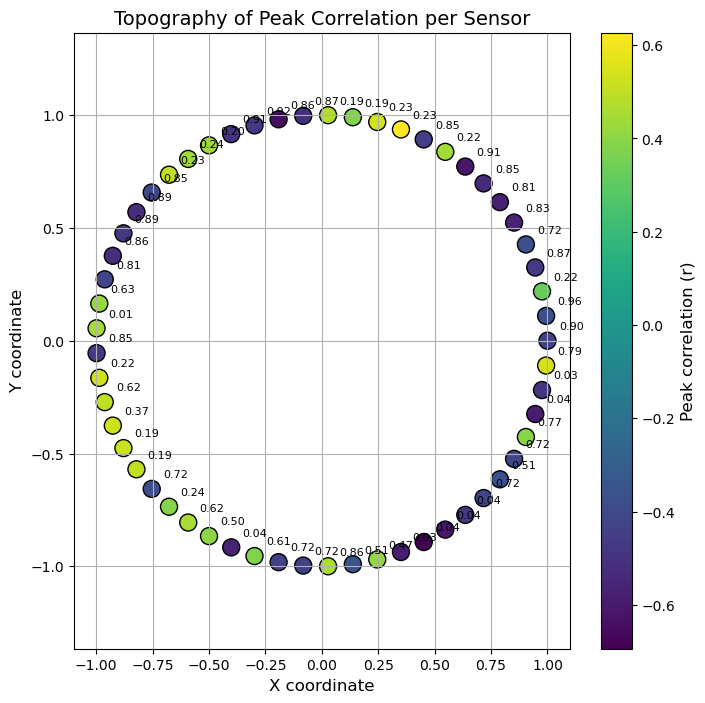

In [190]:
### GPT Prompt: How to plot the topography of this?? ###
## Step 1. Suppose You Already Have Your Peak Values ##

peak_time = np.zeros(n_sensors)
peak_r = np.zeros(n_sensors)

for ch in range(n_sensors):
    # Find the index of maximum absolute r for each sensor.
    peak_idx = np.argmax(np.abs(r_vals[ch, :]))
    peak_time[ch] = time[peak_idx]
    peak_r[ch] = r_vals[ch, peak_idx]

# Print results:
for ch in range(n_sensors):
    print(f"Sensor {ch}: Peak correlation at time = {peak_time[ch]:.3f} s, r = {peak_r[ch]:.3f}")

## Step 2. Generate (or Obtain) Sensor Coordinates ##
#import numpy as np

n_sensors = 57

# Simulate sensor positions on a circle:
angles = np.linspace(0, 2*np.pi, n_sensors, endpoint=False)
radius = 1.0  # You can adjust the radius if needed.
sensor_x = radius * np.cos(angles)
sensor_y = radius * np.sin(angles)

## Step 3. Plot the Topography Using Matplotlib ##
#import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Create a scatter plot: sensor positions colored by the peak r value.
sc = plt.scatter(sensor_x, sensor_y, c=peak_r, cmap='viridis', s=150, edgecolor='k')

# Add a colorbar to indicate the mapping of color to correlation magnitude.
cbar = plt.colorbar(sc)
cbar.set_label('Peak correlation (r)', fontsize=12)

# Optionally, annotate each sensor with its peak time value.
for i in range(n_sensors):
    plt.text(sensor_x[i]+0.05, sensor_y[i]+0.05, f"{peak_time[i]:.2f}", fontsize=8)

plt.title("Topography of Peak Correlation per Sensor", fontsize=14)
plt.xlabel("X coordinate", fontsize=12)
plt.ylabel("Y coordinate", fontsize=12)
plt.axis("equal")  # Ensure the aspect ratio is 1:1 for a proper head shape.
plt.grid(True)
plt.show()



In [191]:
## Example 1: Using an Existing Sensor Dimension

#import eelbrain as eb
#import matplotlib.pyplot as plt
#import numpy as np

# Suppose you have an NDVar 'r_ndvar' with shape (n_sensors, n_timepoints)
# where its sensor dimension has a layout, for example:
#    r_ndvar.dims   --> [sensor, time]

# And suppose you computed peak correlations per sensor already:
# peak_r: a NumPy array of shape (n_sensors,)
# peak_time: a NumPy array of shape (n_sensors,) (time of peak; may be shown as annotations)

# Extract the sensor dimension from your NDVar:
sensor_dim = r_ndvar.get_dim("sensor")  # This dimension may already have layout info

# Create a new NDVar for the peak correlations:
peak_r_ndvar = eb.NDVar(peak_r, dims=[sensor_dim])

# Now use Eelbrain’s topoplot function to plot the topography.
# This uses the sensor layout stored in sensor_dim.layout.
eb.topoplot(peak_r_ndvar, title="Topography of Peak Correlation (r)", colorbar=True)
plt.show()


NameError: name 'r_ndvar' is not defined

In [126]:
print(len(ds["data"][0]))

26


In [137]:
## Step 1. Create Dimension Objects for Group-Level NDVars ##
# Assuming 57 sensors and 114 time points.
n_sensors = len(ds["data"][0]) #57
n_timepoints = len(ds["data"][0][0]) # 114

# Create a sensor dimension with labels 0 through 56.
sensor_dim = eelbrain.Categorial("sensor", list(str(range(n_sensors))))

# Create a time dimension.
# Example: 114 time points from 0 to 1 second. Adjust the time range as needed.
time_points = np.linspace(0, 1, n_timepoints)
time_dim = eelbrain.UTS(0, 1, n_timepoints)
#time_dim = eelbrain.TimeDim(time_points)

## Step 2. Convert r_vals and p_vals Arrays to NDVar Objects ##


# (Assume data and vst are already defined)
r_vals = np.zeros((n_sensors, n_timepoints))
p_vals = np.zeros((n_sensors, n_timepoints))


for ch in range(n_sensors):      # For each sensor
    for t in range(n_timepoints):  # For each time point
        values = ds[:, ch, t]     # Get all subjects’ readings at sensor ch, time t
        r, p = pearsonr(values, vst)  # Compute correlation (r) and p-value (p)
        r_vals[ch, t] = r
        p_vals[ch, t] = p

# Assume r_vals and p_vals were computed as in your loop.
# r_vals and p_vals are both of shape (n_sensors, n_timepoints).
r_ndvar = eelbrain.NDVar(r_vals, dims=[sensor_dim, time_dim])
p_ndvar = eelbrain.NDVar(p_vals, dims=[sensor_dim, time_dim])

KeyError: 'Invalid index for Dataset: (slice(None, None, None), 0, 0)'

In [ ]:
### import eelbrain as eb
#import matplotlib.pyplot as plt
#import numpy as np

# --- Data Assumptions ---
# trf: an NDVar with the TRF for F0; dimensions: (subjects, time)
# ds: an Eelbrain Dataset with at least one column "VST" that holds vocabulary size test scores.
# (These objects should already be loaded/created)

# --- Run Multiple Regression ---
# The following code fits a linear model (LM) where the TRF is predicted by the VST score.
res_all_lm = eelbrain.testnd.LM('Fzero+envelope+onset', 'VST', data=n_trfs)#ds)
print(type(res_all_lm))
#res_all_LMGroup = eelbrain.testnd.LMGroup(res_all_lm)#ds)
#res_F0 = eelbrain.testnd.LM('Fzero', 'VST', data=n_trfs['Fzero'])#ds)
#res_all_LMGroup

In [51]:
sub_All_F0_Array = plot.TopoArray(n_rows, t=[0.13, 0.3], title="F0")
sub_All_F0_Array.save(DST / Path("SUB_ALL_F0_array"))

TypeError: NDVar required, got 30

In [20]:
"""
# --- Plot the Regression Coefficient (r timeline) ---
# This plots the effect (beta, which is equivalent to correlation if predictors are standardized) over time.
# The default plot method marks significant time points (if any) based on the internal threshold.
res['VST'].plot()
plt.title("Regression Coefficient (r) Timeline for VST")
plt.xlabel("Time (ms)")
plt.ylabel("Coefficient (r)")
plt.show()

"""
p_all_VST = eelbrain.plot.TopoArray(res_all_lm, t=[0.1, 0.42, 0.7], head_radius=0.35) #, t=[0.120, 0.155, None], title=result
p_cb_all = p_all_VST.plot_colorbar(right_of=p_all_VST.axes[0], label='t')
p_all_VST.save(DST / "sub%s_F0" %str(sub_[0]))

"""
p_F0_VST = eelbrain.plot.TopoArray(res_F0, head_radius=0.35) #, t=[0.120, 0.155, None], title=result
p_cb_F0 = p_F0_VST.plot_colorbar(right_of=p_F0_VST.axes[0], label='t')
p_F0_VST
"""

"\np_F0_VST = eelbrain.plot.TopoArray(res_F0, head_radius=0.35) #, t=[0.120, 0.155, None], title=result\np_cb_F0 = p_F0_VST.plot_colorbar(right_of=p_F0_VST.axes[0], label='t')\np_F0_VST\n"

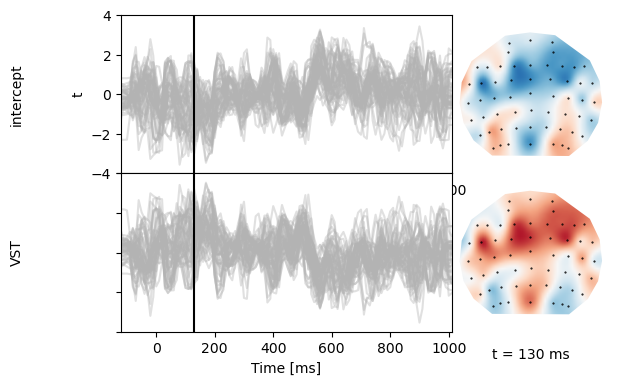

In [23]:
p_all_VST_butterfly = plot.TopoButterfly(res_all, t=0.130, axh=2, w=6)
p_all_VST_butterfly

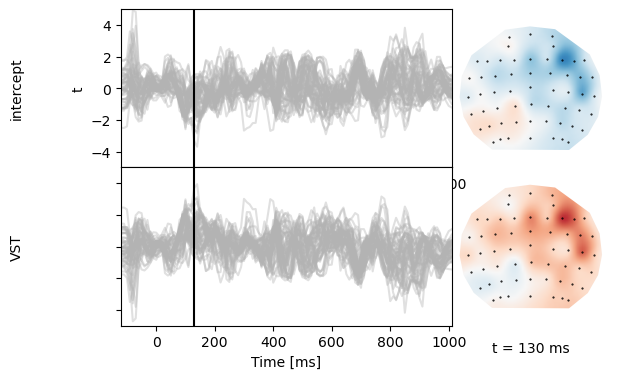

In [22]:
p_F0_VST_butterfly = plot.TopoButterfly(res_F0, t=0.130, axh=2, w=6)
p_F0_VST_butterfly

In [27]:
lm = testnd.LM(n_trfs['Fzero'], 'VST', data=n_trfs, samples=0) #, subject=str(subject))
pprint(lm)

<LM 'Fzero', 'VST', samples=0>


In [167]:
n_trfs = eelbrain.Dataset.from_caselist(['subject', 'model', "VST" ,*n_trf.x], n_rows)
print(n_trfs)
print(type(n_trfs))

subject   model                      VST
----------------------------------------
30        Fzero+envelope+env_onset   7  
27        Fzero+envelope+env_onset   8  
23        Fzero+envelope+env_onset   5.1
34        Fzero+envelope+env_onset   7.2
24        Fzero+envelope+env_onset   6.1
19        Fzero+envelope+env_onset   6.7
20        Fzero+envelope+env_onset   5.2
13        Fzero+envelope+env_onset   8.2
17        Fzero+envelope+env_onset   7.5
39        Fzero+envelope+env_onset   7.7
10        Fzero+envelope+env_onset   6.7
29        Fzero+envelope+env_onset   6.4
15        Fzero+envelope+env_onset   8.4
28        Fzero+envelope+env_onset   8.8
11        Fzero+envelope+env_onset   7.3
38        Fzero+envelope+env_onset   7.3
16        Fzero+envelope+env_onset   6.4
12        Fzero+envelope+env_onset   7.8
21        Fzero+envelope+env_onset   5.3
36        Fzero+envelope+env_onset   7.3
32        Fzero+envelope+env_onset   6.6
25        Fzero+envelope+env_onset   7.9
35        Fzero+

In [166]:
lmsLIST = []

for trf_subject in n_trfs:
    print(trf_subject['Fzero'])
    #print(trf_subject[3].x) # Fzero data
    #print(trf_subject[2]) # VST
    #n_rows.append([n_subj, model, VST_scoreFLOAT, *n_trf.h_scaled])
    #lm = testnd.LM(trf_subject[3], trf_subject[1], data=trf_subject, samples=0, subject=str(subject))
    #print(lm)
    #lms.append(lm)
#print(lmsLIST)

TypeError: string indices must be integers, not 'str'

In [135]:
# Basic regression: TRF ~ language_score
F0_VST_res = testnd.LM('Fzero', 'VST', data=n_trfs)
print(F0_VST_res)

Permutation test:   0%|          | 0/10000 [00:00<?, ? permutations/s]

<LM 'Fzero', 'VST', samples=10000, 'intercept': p = .114, 'VST': p = .096>


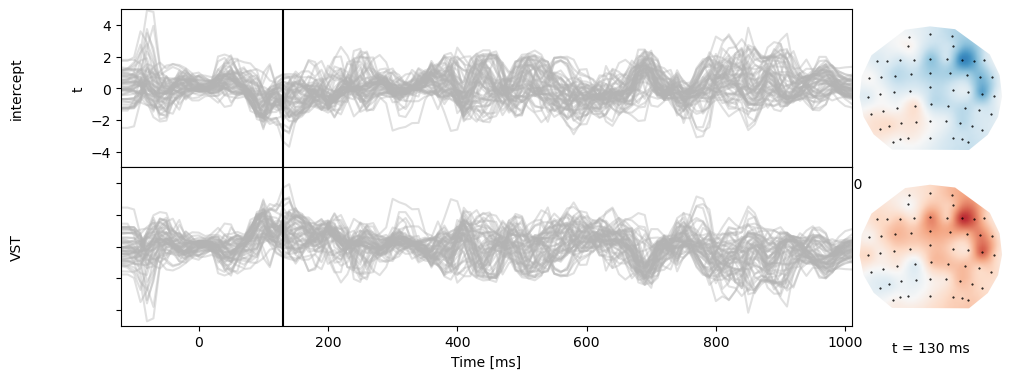

In [145]:
p_F0_VST = eelbrain.plot.TopoButterfly(F0_VST_res, t=0.130, axh=2, w=10)
#p_F0_bar = p_F0.plot_colorbar(label="F0", width=0.1)
p_F0_VST